In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler, StandardScaler

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score

In [2]:
df_orig = pd.read_excel('..\data\Evolytics Data Science Exercise.xlsx')
df = df_orig.copy()
df_orig

source_visitor_id  visit_num  First_Visit  \
0     5265991230000000000000000000000000000        254            0   
1     5265991230000000000000000000000000000        218            0   
2     5267850000000000000000000000000000000          1            1   
3     5267860000000000000000000000000000000          1            1   
4     5267870000000000000000000000000000000          2            0   
...                                     ...        ...          ...   
8613  5337932166667980000000000000000000000          2            0   
8614  5337940333334640000000000000000000000          1            1   
8615  5337948500001310000000000000000000000          1            1   
8616  5337956666667980000000000000000000000          1            1   
8617  5337964833334640000000000000000000000          2            0   

           date min_timestamp_date min_timestamp_time       max_timestamp  \
0    2017-03-30         2017-03-30           13:56:52 2017-03-30 14:00:00   
1    2016-12-09         2016-12-09           13:11:32 2016-12-09 13:15:00   
2    2016-11-23         2016-11-23           13:53:07 2016-11-23 14:00:00   
3    2016-11-21         2016-11-21           11:05:09 2016-11-21 11:35:00   
4    2017-04-05         2017-04-05           07:34:11 2017-04-05 07:46:00   
...         ...                ...                ...                 ...   
8613 2017-04-20         2017-04-20           01:22:24 2017-04-20 01:29:00   
8614 2017-04-19         2017-04-19           16:14:51 2017-04-19 16:24:00   
8615 2017-04-19         2017-04-19           17:48:18 2017-04-19 18:40:00   
8616 2017-04-19         2017-04-19           19:03:44 2017-04-19 19:16:00   
8617 2017-07-10         2017-07-10           08:31:04 2017-07-10 09:00:00   

                             Recipe  purchase_flag  no_thanks_flag  ...  \
0     Recipe B | Upgrade Suggestive              1               1  ...   
1     Recipe B | Upgrade Suggestive              1               1  ...   
2     Recipe B | Upgrade Suggestive              1               1  ...   
3     Recipe B | Upgrade Suggestive              1               1  ...   
4     Recipe B | Upgrade Suggestive              1               1  ...   
...                             ...            ...             ...  ...   
8613  Recipe B | Upgrade Suggestive              0               0  ...   
8614  Recipe B | Upgrade Suggestive              1               1  ...   
8615  Recipe B | Upgrade Suggestive              0               0  ...   
8616  Recipe B | Upgrade Suggestive              1               1  ...   
8617  Recipe B | Upgrade Suggestive              1               0  ...   

      Safari_Browser  SeaMonkey_Browser  Test2 landpage-hiking  \
0                  1                  0      1               0   
1                  1                  0      1               0   
2                  0                  0      1               0   
3                  0                  0      1               0   
4                  1                  0      1               0   
...              ...                ...    ...             ...   
8613               0                  0      1               0   
8614               1                  0      1               0   
8615               0                  0      1               0   
8616               0                  0      1               0   
8617               0                  0      1               0   

     landpage camping landpage run loyalty_user landpage winter SEO SEM  
0                   0            0        False               0   0   1  
1                   0            0        False               0   0   1  
2                   0            0        False               0   1   0  
3                   0            0        False               0   1   0  
4                   0            0        False               0   1   0  
...               ...          ...          ...             ...  ..  ..  
8613                0            0  

In [6]:
df.dtypes

source_visitor_id              object
visit_num                       int64
First_Visit                     int64
date                   datetime64[ns]
min_timestamp_date     datetime64[ns]
                           ...       
SEM                             int64
min_time               datetime64[ns]
visit_dur             timedelta64[ns]
day_of_week                     int64
visit_day                       int64
Length: 84, dtype: object

In [3]:
# !pip install pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='B test stats')

In [4]:
profile

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


In [3]:
# Engineer a vist duration feature
df['min_time'] = df.apply(lambda x : pd.datetime.combine(x['min_timestamp_date'],x['min_timestamp_time']),1)
df['visit_dur'] = df['max_timestamp'] - df['min_time']
# Time before popup may be a more relevant metric
df[['visit_dur', 'time_before_popup']]

# Let's extract the day
df['day_of_week'] = df['date'].dt.dayofweek
df['visit_day'] = df['date'].dt.day
df['hour'] = df['min_timestamp_time'].apply(lambda x: x.hour)

In [4]:
# let's try to predict upgrade_and_purchase using only features not from the B Recipe itself
features = ['day_of_week', 'hour', 'visit_day', 'visit_num', 'First_Visit', 'IPD', 
            'operating_system_family', 'browser_family', 'user_State',
            'pageviews_before_popup', 'time_before_popup', 'hits_before_popup',
            'loyalty_user' #, 'landpage winter', 'SEM','camp_page_flag', 'hiking__page_flag', 'kayak_page_flag',
            ]
target = 'upgrade_and_purchase'

In [5]:
# split the data. Import to stratify to keep the class balance
train, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df[target])
train.shape, test.shape

((7325, 85), (1293, 85))

In [6]:

X_train, X_test = train.copy(), test.copy()
X_train = X_train[features]
X_test = X_test[features]

y_train, y_test = train[target], test[target]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7325, 13), (1293, 13), (7325,), (1293,))

In [7]:
# Baseline majority class. Highly imbalanced
print(len(y_train[y_train==1]), len(y_train[y_train==0]), round(6665/660, 2))
print("Majority Class Accuracy: {:.4f}".format(accuracy_score(y_true=y_test, y_pred=[0]*len(y_test))))

660 6665 10.1
Majority Class Accuracy: 0.9095


In [8]:
# We will need to encode our variables for this
# Target encode categorical variables, Robust scale everything
from category_encoders.target_encoder import TargetEncoder

te = TargetEncoder(cols=['day_of_week', 'visit_day', 'operating_system_family', 'browser_family', 'user_State', 'loyalty_user'])
X_lr_train_enc = te.fit_transform(X=X_train, y=y_train)
X_lr_test_enc = te.transform(X_test)

# note: Scaling had no effect on the accuracy
rs = StandardScaler() #RobustScaler()
X_train_scaled = rs.fit_transform(X_lr_train_enc)
X_test_scaled = rs.transform(X_lr_test_enc)


In [9]:
# Run logistic regression

lr = LogisticRegression(n_jobs=-3)
lr_model = lr.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)
print("Logistic regression baseline accuracy: {:.4f}".format(accuracy_score(y_true=y_test, y_pred=y_pred)))

Logistic regression baseline accuracy: 0.9103


In [10]:
## Now let's try a Random Forest Classifier. We don't necessarily need day of week to be categorical here, but it's already done
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-3, random_state=42, n_estimators=22)
rf_model = rf.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
print("Random Forest Classifier accuracy: {:.4f}".format(accuracy_score(y_true=y_test, y_pred=y_pred)))

Random Forest Classifier accuracy: 0.9087


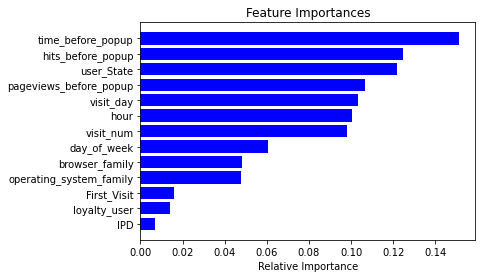

In [11]:

importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
# Think about each relationship

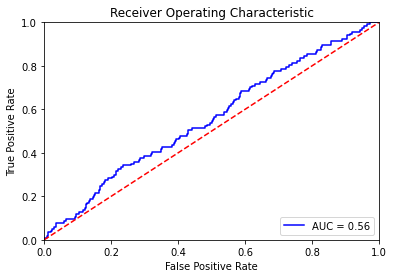

In [18]:
# Up next use predict_proba for roc auc curve
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_model.predict_proba(X_test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


DescribeResult(nobs=1293, minmax=(0.0, 0.5909090909090909), mean=0.10324825986078887, variance=0.008116887357282878, skewness=1.1790927837933625, kurtosis=1.9080422933004)


Text(0.5, 6.79999999999999, 'Prediction_Probability_of_Upsell')

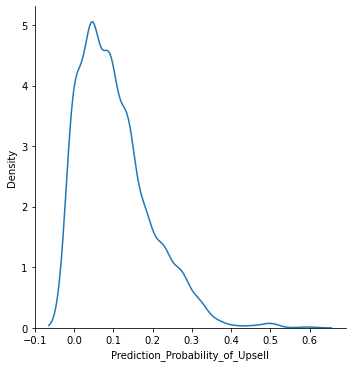

In [15]:
from scipy.stats import describe
print(describe(preds))
# Looking at the dist of these predicions, we can see why it's so hard to capture the true positives without the false positives
import seaborn as sns

sns.displot(preds, kind='kde')
plt.xlabel('Prediction_Probability_of_Upsell')

Average precision-recall score: 0.12


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.12')

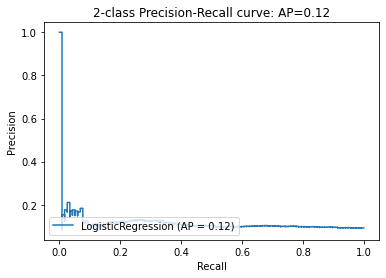

In [16]:
# This is indicative of a highly imbalanced target variable. Just by guessing 'upgrade_and_purchase' = 0 
# most of the time, we get a good accuracy. But the model needs to improve at distinguishing true pos and false post
y_score = lr_model.decision_function(X_test_scaled)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(lr_model, X_test_scaled, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [17]:
# !pip install imblearn

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# define pipeline
model = rf_model
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
scores = cross_val_score(pipeline, X_train_scaled, y_train, scoring='roc_auc', cv=cv, n_jobs=-3)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.565


In [20]:
# Would they actually improve revenue, and how much. Conversion(80 index), revenue(95index)
# Feature engineering
# hyper param tuning
# neural network
# Heres what I would need to meet the goals
    # User profile on past behavoir/purchases
        # With this you can build a straight recommender system, using KNN--users who like this, often like this...
    # This is the start

# despite shortcoming of model, show investigation of tools and process. Demonstrate work
# How far into this until realized you can't improve
# Im going to get technical, to showcase work

# If technical, learn new skill quickly
# For soft skill pivot to team examples that same qualities

# Have 3 stories

# End ask for questions

In [21]:
# Neural Network 
nn_model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
nn_model.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [22]:
y_pred = nn_model.predict(X_test_scaled)
print("Neural Network Classifier accuracy: {:.4f}".format(accuracy_score(y_true=y_test, y_pred=y_pred)))

Neural Network Classifier accuracy: 0.8863


Stochastic Gradient Descent Classifier accuracy: 0.9103


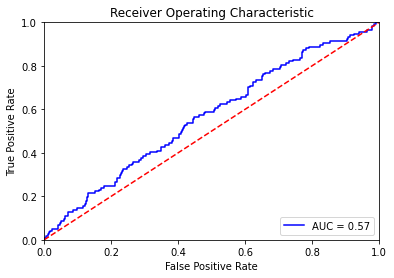

In [57]:
# Stochastic Gradient Descent
sgd = SGDClassifier(loss='log')
sgd.fit(X_train_scaled, y_train)
y_pred = sgd.predict(X_test_scaled)
print("Stochastic Gradient Descent Classifier accuracy: {:.4f}".format(accuracy_score(y_true=y_test, y_pred=y_pred)))

# calculate the fpr and tpr for all thresholds of the classification
probs = sgd.predict_proba(X_test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [61]:
df['time_before_popup'].describe()

count    8618.000000
mean        0.005978
std         0.006829
min        -0.017000
25%         0.002000
50%         0.003600
75%         0.007100
max         0.094400
Name: time_before_popup, dtype: float64

In [59]:
from sklearn.pipeline import make_pipeline
lr_pipeline = make_pipeline(
   TargetEncoder(),
   StandardScaler(),
   LogisticRegression()
)
lr_pipeline.fit(X_train, y_train)
lr_pipeline.predict_proba(X_test.iloc[0:1])[0][1]

0.035668500826042865

In [60]:
# Pickle the model
from joblib import dump, load
dump(lr_pipeline, 'lr_classifier.joblib')


['lr_classifier.joblib']

In [62]:
loaded_model = load('lr_classifier.joblib')
loaded_model.predict_proba(X_test)

array([[0.9643315 , 0.0356685 ],
       [0.89515685, 0.10484315],
       [0.93607596, 0.06392404],
       ...,
       [0.88280198, 0.11719802],
       [0.91848956, 0.08151044],
       [0.68375756, 0.31624244]])

In [65]:
X_test.iloc[0]

day_of_week                        1
hour                              10
visit_day                         29
visit_num                          1
First_Visit                        1
IPD                                0
operating_system_family    Windows 7
browser_family                Chrome
user_State                        KS
pageviews_before_popup             6
time_before_popup             0.0041
hits_before_popup                 13
loyalty_user                   False
Name: 5044, dtype: object

In [66]:
X_test.dtypes

day_of_week                  int64
hour                         int64
visit_day                    int64
visit_num                    int64
First_Visit                  int64
IPD                          int64
operating_system_family     object
browser_family              object
user_State                  object
pageviews_before_popup       int64
time_before_popup          float64
hits_before_popup            int64
loyalty_user                  bool
dtype: object